### Import libraries

In [1]:
import numpy as np
import tensorflow as tf
from collections import Counter
import tensorflow_federated as tff
import matplotlib.pyplot as plt
from scipy import stats
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import nest_asyncio
nest_asyncio.apply()

# تنظیم بذر تصادفی برای تکرارپذیری
np.random.seed(42)
tf.random.set_seed(42)

# تنظیم زمینه اجرایی محلی
tff.backends.native.set_local_execution_context()

C:\Users\TOP\anaconda3\envs\evn8\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.18.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### MNIST Preprocessing

In [2]:
# بارگذاری داده‌ها
(x_train_m, y_train_m), (x_test_m, y_test_m) = mnist.load_data()

# نرمال‌سازی داده‌ها
x_train_m = x_train_m.astype('float32') / 255.0
x_test_m = x_test_m.astype('float32') / 255.0

# اضافه کردن ابعاد کانال (برای MLP نیازی به این کار نیست، اما برای سازگاری با ورودی‌های مختلف)
x_train_m = x_train_m.reshape((x_train_m.shape[0], -1))  # به شکل (batch_size, 784) تبدیل می‌شود
x_test_m = x_test_m.reshape((x_test_m.shape[0], -1))    # به شکل (batch_size, 784) تبدیل می‌شود

# کدگذاری برچسب‌ها
y_train_m = tf.keras.utils.to_categorical(y_train_m, 10)
y_test_m = tf.keras.utils.to_categorical(y_test_m, 10)

### Create MLP Model For MNIST

In [3]:
def create_mnist_mlp_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,)))     # ورودی به شکل مسطح شده (28x28 = 784)
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))     # لایه خروجی با 10 کلاس (softmax)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])     # کامپایل کردن مدل
    return model

### Split Data For Models

In [4]:
def split_data(x, y, num_splits):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    split_indices = np.array_split(indices, num_splits)
    split_data = [(x[indices], y[indices]) for indices in split_indices]  
    return split_data
    
# تقسیم داده‌ها به کلاینت‌ها
num_models = 5
client_data_m = split_data(x_train_m, y_train_m, num_models)

accuracy_no_bug = []  # دقت برای حالت بدون نرمال‌سازی دوباره
accuracy_with_bug = []  # دقت برای حالت با نرمال‌سازی دوباره برای کلاینت 3
client_models_m = []  # لیست برای ذخیره مدل‌های هر کلاینت

# حالت بدون نرمال‌سازی دوباره
for i in range(len(client_data_m)):
    model_data_m = client_data_m[i]
    model_mnist = create_mnist_mlp_model()
    
    # آموزش مدل
    model_mnist.fit(model_data_m[0], model_data_m[1], epochs=5, batch_size=32, verbose=1)
    client_models_m.append(model_mnist)
    
    # ارزیابی دقت مدل بر روی داده‌های تست
    loss, accuracy = model_mnist.evaluate(x_test_m, y_test_m, verbose=0)
    accuracy_no_bug.append(accuracy)  # ذخیره دقت برای حالت بدون نرمال‌سازی دوباره

# حالا، برای آموزش با نرمال‌سازی دوباره برای کلاینت 3
client_models_m = []  # لیست برای ذخیره مدل‌های هر کلاینت (دوباره خالی می‌شود)
for i in range(len(client_data_m)):
    model_data_m = client_data_m[i]
    model_mnist = create_mnist_mlp_model()
    if i in [1,3]: 
        model_data_m = (model_data_m[0] / 255.0, model_data_m[1])
    
    # آموزش مدل
    model_mnist.fit(model_data_m[0], model_data_m[1], epochs=5, batch_size=32, verbose=1)
    client_models_m.append(model_mnist)
    
    # ارزیابی دقت مدل بر روی داده‌های تست
    loss, accuracy = model_mnist.evaluate(x_test_m, y_test_m, verbose=0)
    accuracy_with_bug.append(accuracy)  # ذخیره دقت برای حالت با نرمال‌سازی دوباره

Epoch 1/5
188/188 [==============================] - 1s 5ms/step - loss: 0.6311 - accuracy: 0.8008
Epoch 2/5
188/188 [==============================] - 1s 5ms/step - loss: 0.2696 - accuracy: 0.9170
Epoch 3/5
188/188 [==============================] - 1s 5ms/step - loss: 0.1683 - accuracy: 0.9498
Epoch 4/5
188/188 [==============================] - 1s 7ms/step - loss: 0.1356 - accuracy: 0.9587
Epoch 5/5
188/188 [==============================] - 1s 8ms/step - loss: 0.0954 - accuracy: 0.9668
Epoch 1/5
188/188 [==============================] - 1s 7ms/step - loss: 0.6482 - accuracy: 0.7945
Epoch 2/5
188/188 [==============================] - 1s 7ms/step - loss: 0.2820 - accuracy: 0.9172
Epoch 3/5
188/188 [==============================] - 1s 8ms/step - loss: 0.1857 - accuracy: 0.9420
Epoch 4/5
188/188 [==============================] - 1s 7ms/step - loss: 0.1484 - accuracy: 0.9537
Epoch 5/5
188/188 [==============================] - 1s 7ms/step - loss: 0.1082 - accuracy: 0.9660
Epoch 1/5


### Plot for accuracy with bug & without bug

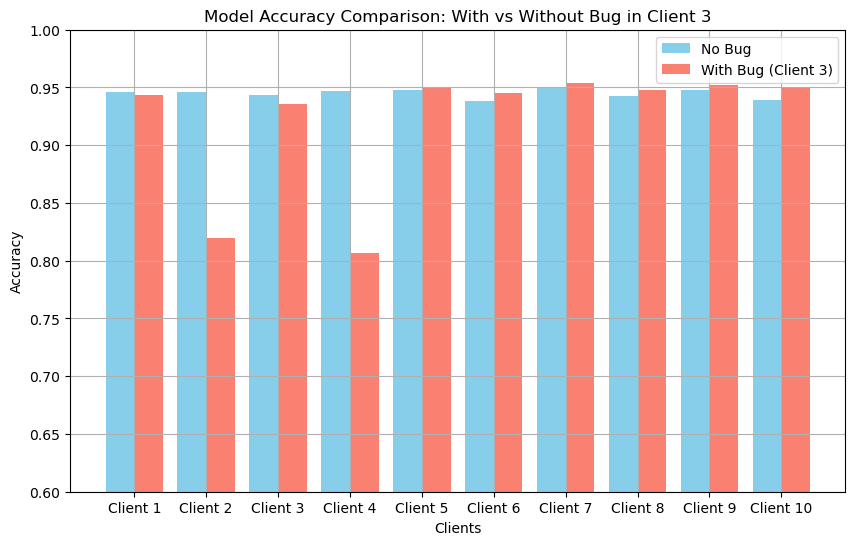

In [5]:
# ایجاد پلات
# تعریف تعداد کلاینت‌ها به صورت دینامیک
num_models = len(client_data_m)  # یا اگر از num_models استفاده می‌کنید: num_clients = num_models
clients = [f'Client {i+1}' for i in range(num_models)]  # ایجاد نام کلاینت‌ها به صورت خودکار

x = np.arange(len(clients))  # محور x

plt.figure(figsize=(10,6))

# ایجاد دو نمودار میله‌ای برای دقت‌ها
plt.bar(x - 0.2, accuracy_no_bug, 0.4, label='No Bug', color='skyblue')
plt.bar(x + 0.2, accuracy_with_bug, 0.4, label='With Bug (Client 3)', color='salmon')

# برچسب‌ها و عنوان
plt.xlabel('Clients')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison: With vs Without Bug in Client 3')
plt.xticks(x, clients)
plt.ylim(0.6, 1.0)  # محدوده دقت بین 0.6 تا 1.0

# نمایش راهنما و پلات
plt.legend()
plt.grid(True)
plt.show()

### Definition of Evaluation Criteria

In [6]:
def delta_class(models, x_test):
    num_models = len(models)
    preds = [model.predict(x_test).argmax(axis=1) for model in models]         # پیش‌بینی‌ها برای هر مدل
    diffs_matrix = np.zeros((num_models, num_models), dtype=int)    # ماتریس مربعی برای ذخیره تفاوت‌ها
    for i in range(num_models):       # پر کردن ماتریس با تفاوت پیش‌بینی‌ها
        for j in range(i+1, num_models):
            diffs = np.sum(preds[i] != preds[j])  # تعداد تفاوت‌های پیش‌بینی بین مدل i و مدل j
            diffs_matrix[i, j] = diffs
            diffs_matrix[j, i] = diffs  # ماتریس متقارن است
    return diffs_matrix

def delta_score(models, x_test):
    num_models = len(models)
    preds = [model.predict(x_test) for model in models]     # پیش‌بینی‌ها برای هر مدل
    diffs_matrix = np.zeros((num_models, num_models))      # ماتریس تفاوت‌ها  
    for i in range(num_models):      # محاسبه تفاوت‌ها برای هر جفت مدل
        for j in range(i+1, num_models):
            diffs = np.mean(np.abs(preds[i] - preds[j]))  # میانگین تفاوت مطلق
            diffs_matrix[i, j] = diffs
            diffs_matrix[j, i] = diffs  # متقارن
    return diffs_matrix

def p_ks(models, x_test):
    num_models = len(models)      
    scores = [model.predict(x_test) for model in models]       # امتیازات پیش‌بینی‌ها برای هر مدل   
    ks_matrix = np.zeros((num_models, num_models))  # ماتریس برای آماره آزمون KS و p-value
    pvalue_matrix = np.zeros((num_models, num_models))    
    # محاسبه آزمون KS برای هر جفت مدل
    for i in range(num_models):
        for j in range(i+1, num_models):          
            ks_stat, p_value = stats.ks_2samp(scores[i].flatten(), scores[j].flatten())  # محاسبه آزمون KS و دریافت آماره و p-value      
            # چک کردن برای جلوگیری از NaN یا Inf
            ks_stat = ks_stat if np.isfinite(ks_stat) else 0
            p_value = p_value if np.isfinite(p_value) else 1   
            # پر کردن ماتریس‌ها
            ks_matrix[i, j] = ks_stat
            ks_matrix[j, i] = ks_stat  # متقارن
            pvalue_matrix[i, j] = p_value
            pvalue_matrix[j, i] = p_value  # متقارن   
    return ks_matrix, pvalue_matrix

def p_x2(models, x_test):
    num_models = len(models)    
    # پیش‌بینی کلاس‌ها برای هر مدل
    preds = [model.predict(x_test).argmax(axis=1) for model in models]    
    p_x2 = np.zeros((num_models, num_models))  # ماتریس برای آماره آزمون کای دو و p-value
    pvalue_matrix = np.zeros((num_models, num_models))    
    # محاسبه آزمون کای دو برای هر جفت مدل
    for i in range(num_models):
        for j in range(i+1, num_models):
            # محاسبه فراوانی کلاس‌های هر دو مدل
            bincount_i = np.bincount(preds[i])
            bincount_j = np.bincount(preds[j])            
            # اطمینان از اینکه هیچ عنصری صفر نباشد (برای جلوگیری از تقسیم بر صفر)
            bincount_i = np.where(bincount_i == 0, 1e-9, bincount_i)
            bincount_j = np.where(bincount_j == 0, 1e-9, bincount_j)           
            x2, p_value = stats.chisquare(bincount_i, bincount_j)         # محاسبه آزمون کای دو و دریافت آماره و p-value     
            # چک کردن برای جلوگیری از NaN یا Inf
            x2 = x2 if np.isfinite(x2) else 0
            p_value = p_value if np.isfinite(p_value) else 1            
            # پر کردن ماتریس‌ها
            p_x2[i, j] = x2
            p_x2[j, i] = x2  # متقارن
            pvalue_matrix[i, j] = p_value
            pvalue_matrix[j, i] = p_value  # متقارن    
    return p_x2, pvalue_matrix

### DBSCAN Implementation

In [7]:
def dbscan(matrix, eps, min_pts):
    n = len(matrix)
    visited = set()  # مجموعه برای نقاط بازدید شده
    clusters = []
    noise = set()  # مجموعه برای نقاط نویز
    point_to_cluster = {}  # دیکشنری برای ذخیره این که هر نقطه به کدام خوشه تعلق دارد

    def get_neighbors(point):
        i, j = point
        return [(i2, j2) for i2 in range(i+1, n) for j2 in range(i2+1, n)
                if matrix[i2, j2] <= eps]

    def expand_cluster(point, neighbors):
        cluster = [point]
        i = 0
        while i < len(neighbors):
            neighbor = neighbors[i]
            if neighbor not in visited:
                visited.add(neighbor)
                neighbor_neighbors = get_neighbors(neighbor)
                if len(neighbor_neighbors) >= min_pts:
                    neighbors.extend(neighbor_neighbors)
            if neighbor not in point_to_cluster:
                if point_to_cluster.get(neighbor) is None:
                    cluster.append(neighbor)
                    point_to_cluster[neighbor] = cluster
                elif point_to_cluster[neighbor] != cluster:
                    # اگر نقطه به خوشه دیگری تعلق دارد، این خوشه را ترکیب نمی‌کنیم
                    continue
            i += 1
        return cluster

    # فقط نقاط بالامثلثی را بررسی می‌کنیم
    upper_triangular_points = [(i, j) for i in range(n) for j in range(i+1, n)]

    for point in upper_triangular_points:
        if point in visited:
            continue

        visited.add(point)
        neighbors = get_neighbors(point)

        if len(neighbors) < min_pts:
            noise.add(point)
        else:
            cluster = expand_cluster(point, neighbors)
            if cluster not in clusters:
                clusters.append(cluster)
            # حذف نقاط خوشه از نویز
            noise -= set(cluster)
    
    return clusters, list(noise)

### Evaluating Metrics and DBSCAN For MNIST

In [8]:
diff_matrix_class_m = delta_class(client_models_m, x_test_m)
print("\nِDifference Matrix For MNIST Delta Class:")
print(diff_matrix_class_m)

diff_matrix_score_m = delta_score(client_models_m, x_test_m)
print("\nِDifference Matrix For MNIST Delta Score:")
print(diff_matrix_score_m)

ks_matrix_m, pvalue_matrix_ks_m = p_ks(client_models_m, x_test_m)
print("\nِKS Statistic Matrix For MNIST:")
print(ks_matrix_m)
print("\nP-value KS Matrix For MNIST:")
print(pvalue_matrix_ks_m)

x2_matrix_m, pvalue_matrix_x2_m = p_x2(client_models_m, x_test_m)
print("\nِChi-squared Distance Matrix For MNIST:")
print(x2_matrix_m)
print("\nP-value X2 Matrix For MNIST:")
print(pvalue_matrix_x2_m)


ِDifference Matrix For MNIST Delta Class:
[[   0 1686  676 1817  556  564  593  508  545  561]
 [1686    0 1736  784 1668 1614 1764 1689 1710 1655]
 [ 676 1736    0 1893  616  644  613  617  600  560]
 [1817  784 1893    0 1792 1744 1909 1841 1847 1793]
 [ 556 1668  616 1792    0  467  499  467  474  485]
 [ 564 1614  644 1744  467    0  532  506  528  480]
 [ 593 1764  613 1909  499  532    0  490  464  504]
 [ 508 1689  617 1841  467  506  490    0  469  484]
 [ 545 1710  600 1847  474  528  464  469    0  469]
 [ 561 1655  560 1793  485  480  504  484  469    0]]

ِDifference Matrix For MNIST Delta Score:
[[0.         0.03545745 0.01545892 0.03814177 0.01299144 0.01294773
  0.01368781 0.0117231  0.01238574 0.0129839 ]
 [0.03545745 0.         0.03699857 0.01564966 0.03498732 0.03352056
  0.03702021 0.0355661  0.03573278 0.0345836 ]
 [0.01545892 0.03699857 0.         0.03984931 0.01471316 0.01526167
  0.01436985 0.01419721 0.01372406 0.01329957]
 [0.03814177 0.01564966 0.03984931 0. 

### Run dbscan for every 4 metrics

In [9]:
print("Run DBSCAN For MNIST:")
eps_mc = 800
min_samples = 22
cluster_c, noise_c = dbscan(diff_matrix_class_m, eps_mc, min_samples)
print("\nFor Class Metric")
print("Outlier:", noise_c)

eps_ms = 0.025
min_samples =22
_, noise_s = dbscan(diff_matrix_score_m, eps_ms, min_samples)
print("\nFor Score Metric")
print("Outlier:", noise_s)

eps_mks = 0.25
min_samples =22
_, noise_ks = dbscan(ks_matrix_m, eps_mks, min_samples)
print("\nFor KS Metric")
print("Outlier:", noise_ks)

eps_mx2 = 450
min_samples = 22
_, noise_x2 = dbscan(x2_matrix_m, eps_mx2, min_samples)
print("\nFor Chi2 Metric")
print("Outlier:", noise_x2)


Run DBSCAN For MNIST:

For Class Metric
Outlier: [(3, 8), (1, 2), (3, 4), (1, 5), (3, 7), (1, 8), (1, 4), (2, 3), (1, 7), (3, 9), (3, 6), (1, 6), (1, 9), (3, 5)]

For Score Metric
Outlier: [(3, 8), (1, 2), (3, 4), (1, 5), (3, 7), (1, 8), (1, 4), (2, 3), (1, 7), (3, 9), (3, 6), (1, 6), (1, 9), (3, 5)]

For KS Metric
Outlier: [(3, 8), (1, 2), (3, 4), (1, 5), (3, 7), (1, 8), (1, 4), (2, 3), (1, 7), (3, 9), (3, 6), (1, 6), (1, 9), (3, 5)]

For Chi2 Metric
Outlier: [(3, 8), (1, 2), (3, 4), (1, 5), (3, 7), (1, 8), (1, 4), (2, 3), (1, 7), (3, 9), (3, 6), (1, 6), (1, 9), (3, 5)]


### Problem customer

In [10]:
def find_most_repeated_values(noise_list):
    # تبدیل لیست به لیست‌های جداگانه از مقادیر
    values = [item for sublist in noise_list for item in sublist]
    # شمارش تکرار در کل لیست
    count = Counter(values)
    # پیدا کردن بیشترین تکرار
    max_count = count.most_common(1)[0][1]
    # یافتن مقادیر با بیشترین تکرار
    most_repeated_values = {item for item, cnt in count.items() if cnt == max_count}
    # چاپ نتایج
    print(f"Problem customer: {sorted(most_repeated_values)}")
# یافتن مقادیر با بیشترین تکرار
find_most_repeated_values(noise_c)
find_most_repeated_values(noise_s)
find_most_repeated_values(noise_ks)
find_most_repeated_values(noise_x2)

Problem customer: [1, 3]
Problem customer: [1, 3]
Problem customer: [1, 3]
Problem customer: [1, 3]


### Plot for Outlier

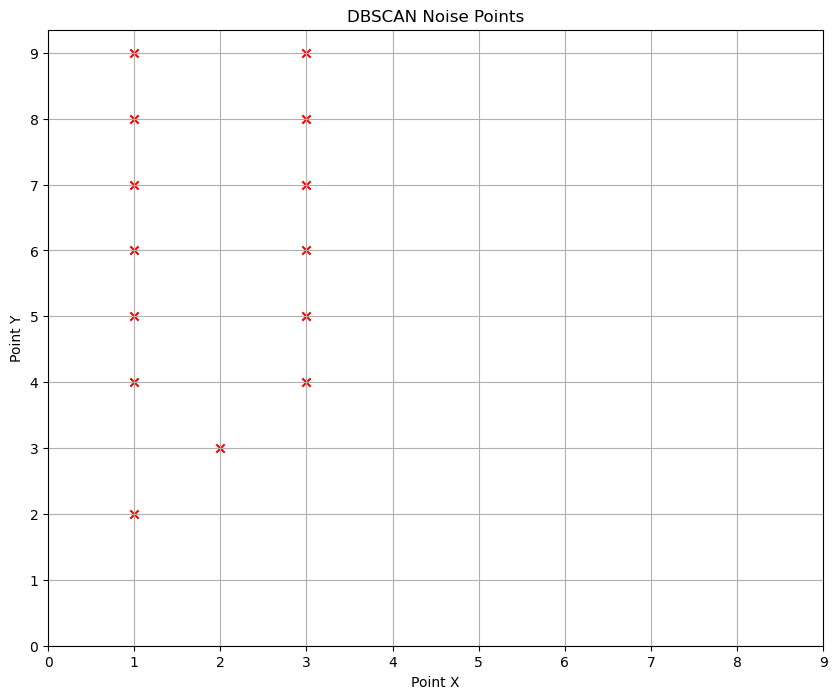

In [11]:
plt.figure(figsize=(10, 8))
n=len(diff_matrix_class_m)
# Plot noise points only
if noise_c:
    noise_points = np.array(noise_c)
    plt.scatter(noise_points[:, 0], noise_points[:, 1], color='red', label="Noise", marker='x')
# Set x and y axis to integer values only
plt.xticks(np.arange(0, n, 1))  # نمایش اعداد صحیح برای محور افقی
plt.yticks(np.arange(0, n, 1))  # نمایش اعداد صحیح برای محور عمودی
# Labeling
plt.title("DBSCAN Noise Points")
plt.xlabel("Point X")
plt.ylabel("Point Y")
plt.grid(True)
plt.show()


### Plot for eps

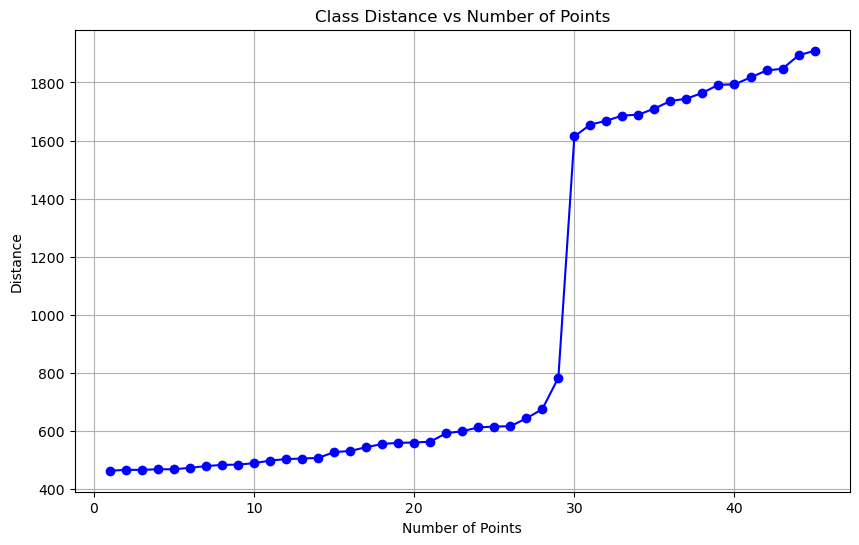

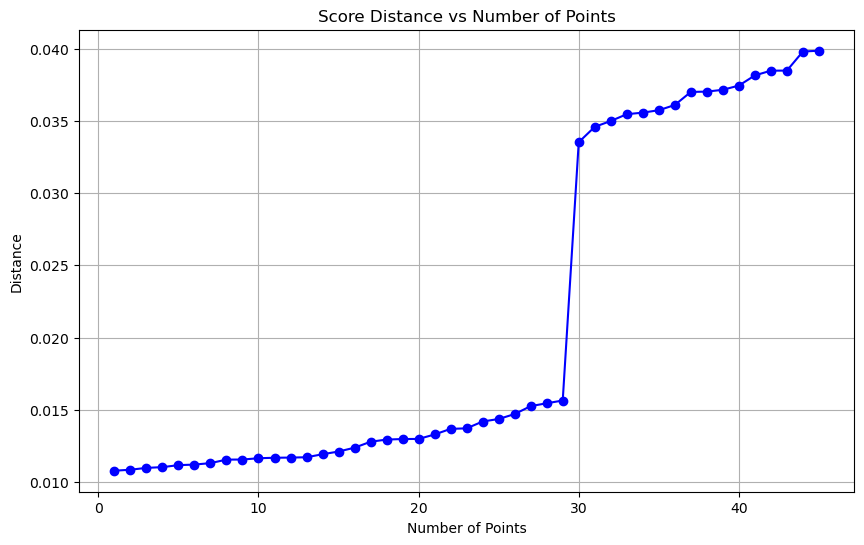

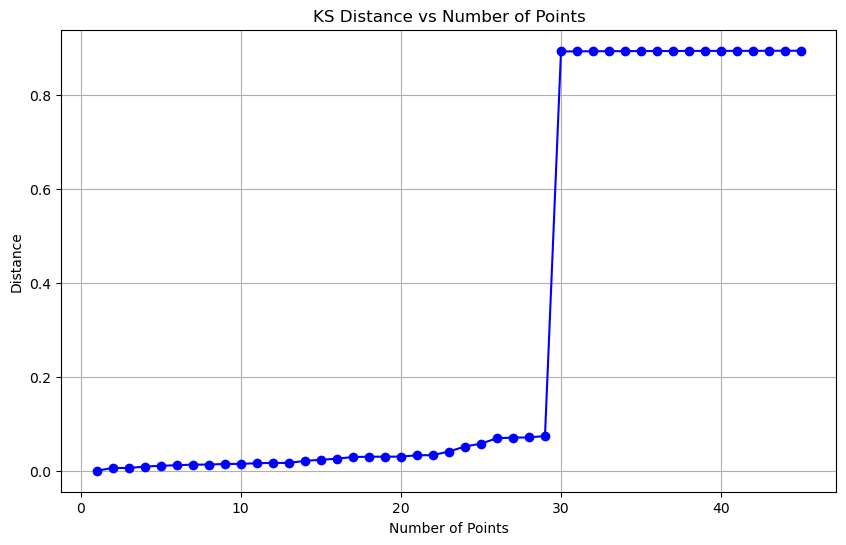

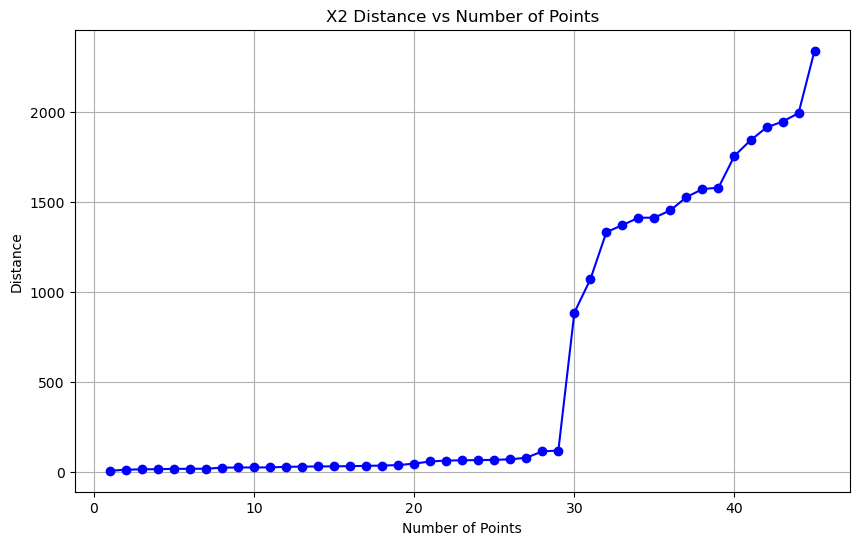

In [12]:
# استخراج مقادیر مثلث بالایی
upper_triangle_indices = np.triu_indices(diff_matrix_class_m.shape[0], k=1)
upper_triangle_values = diff_matrix_class_m[upper_triangle_indices]
# مرتب کردن مقادیر فاصله
sorted_distances = np.sort(upper_triangle_values)
# تعداد نقاط (برای رسم نمودار)
num_points = np.arange(1, len(sorted_distances) + 1)
# ترسیم نمودار
plt.figure(figsize=(10, 6))
plt.plot(num_points, sorted_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Points')
plt.ylabel('Distance')
plt.title('Class Distance vs Number of Points')
plt.grid(True)
plt.show()


upper_triangle_indices = np.triu_indices(diff_matrix_score_m.shape[0], k=1)
upper_triangle_values = diff_matrix_score_m[upper_triangle_indices]
# مرتب کردن مقادیر فاصله
sorted_distances = np.sort(upper_triangle_values)
# تعداد نقاط (برای رسم نمودار)
num_points = np.arange(1, len(sorted_distances) + 1)
# ترسیم نمودار
plt.figure(figsize=(10, 6))
plt.plot(num_points, sorted_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Points')
plt.ylabel('Distance')
plt.title('Score Distance vs Number of Points')
plt.grid(True)
plt.show()


upper_triangle_indices = np.triu_indices(ks_matrix_m.shape[0], k=1)
upper_triangle_values = ks_matrix_m[upper_triangle_indices]
# مرتب کردن مقادیر فاصله
sorted_distances = np.sort(upper_triangle_values)
# تعداد نقاط (برای رسم نمودار)
num_points = np.arange(1, len(sorted_distances) + 1)
# ترسیم نمودار
plt.figure(figsize=(10, 6))
plt.plot(num_points, sorted_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Points')
plt.ylabel('Distance')
plt.title('KS Distance vs Number of Points')
plt.grid(True)
plt.show()


upper_triangle_indices = np.triu_indices(x2_matrix_m.shape[0], k=1)
upper_triangle_values = x2_matrix_m[upper_triangle_indices]
# مرتب کردن مقادیر فاصله
sorted_distances = np.sort(upper_triangle_values)
# تعداد نقاط (برای رسم نمودار)
num_points = np.arange(1, len(sorted_distances) + 1)
# ترسیم نمودار
plt.figure(figsize=(10, 6))
plt.plot(num_points, sorted_distances, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Points')
plt.ylabel('Distance')
plt.title('X2 Distance vs Number of Points')
plt.grid(True)
plt.show()

### Debug process in federated learning

In [15]:
# تعریف مدل Keras
def create_keras_mnist_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(784,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model
# تعریف مدل فدرال
def create_federated_mnist_model():
    keras_model = create_keras_mnist_model()
    return tff.learning.from_keras_model(
        keras_model=keras_model,
        input_spec=(tf.TensorSpec(shape=[None, 784], dtype=tf.float32),  # تغییر شکل ورودی به (784,) برای مدل MLP
                    tf.TensorSpec(shape=[None, 10], dtype=tf.float32)),
        loss=tf.keras.losses.CategoricalCrossentropy(),  # استفاده از CategoricalCrossentropy برای برچسب‌های One-hot
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
def debug_process(models, round_num):
    if round_num % 3 == 0:
        # مرحله اول: محاسبه معیارها
        delta_class_matrix = delta_class(models, test_data)
        delta_score_matrix = delta_score(models, test_data)
        ks_matrix, _ = p_ks(models, test_data)
        x2_matrix, _ = p_x2(models, test_data)

        # تنظیم دستی پارامترها برای هر معیار
        print("Current delta_class_matrix:", delta_class_matrix)
        eps_delta_class = float(input("Enter the value for eps (for DBSCAN on delta_class_matrix): "))
        min_pts_delta_class = int(input("Enter the value for min_pts (for DBSCAN on delta_class_matrix): "))
        
        print("Current delta_score_matrix:", delta_score_matrix)
        eps_delta_score = float(input("Enter the value for eps (for DBSCAN on delta_score_matrix): "))
        min_pts_delta_score = int(input("Enter the value for min_pts (for DBSCAN on delta_score_matrix): "))
        
        print("Current ks_matrix:", ks_matrix)
        eps_ks = float(input("Enter the value for eps (for DBSCAN on ks_matrix): "))
        min_pts_ks = int(input("Enter the value for min_pts (for DBSCAN on ks_matrix): "))
        
        print("Current x2_matrix:", x2_matrix)
        eps_x2 = float(input("Enter the value for eps (for DBSCAN on x2_matrix): "))
        min_pts_x2 = int(input("Enter the value for min_pts (for DBSCAN on x2_matrix): "))

        # مرحله دوم: اجرای DBSCAN برای هر معیار
        clusters_delta_class, noise_clients_delta_class = dbscan(delta_class_matrix, eps=eps_delta_class, min_pts=min_pts_delta_class)
        clusters_delta_score, noise_clients_delta_score = dbscan(delta_score_matrix, eps=eps_delta_score, min_pts=min_pts_delta_score)
        clusters_ks, noise_clients_ks = dbscan(ks_matrix, eps=eps_ks, min_pts=min_pts_ks)
        clusters_x2, noise_clients_x2 = dbscan(x2_matrix, eps=eps_x2, min_pts=min_pts_x2)

        # مرحله سوم: پیدا کردن و حذف کلاینت‌های مشکل‌دار
        problematic_clients_delta_class = find_most_repeated_values(noise_clients_delta_class)
        problematic_clients_delta_score = find_most_repeated_values(noise_clients_delta_score)
        problematic_clients_ks = find_most_repeated_values(noise_clients_ks)
        problematic_clients_x2 = find_most_repeated_values(noise_clients_x2)

        # ترکیب کلاینت‌های مشکل‌دار از هر چهار معیار
        problematic_clients = set(problematic_clients_delta_class).union(
            problematic_clients_delta_score,
            problematic_clients_ks,
            problematic_clients_x2
        )

        # حذف کلاینت‌های مشکل‌دار از فرآیند
        return problematic_clients
    return None
    
# # فرآیند آموزش و به‌روزرسانی سرور
# federated_averaging_process = tff.learning.build_federated_averaging_process(model_fn)

# # پیاده‌سازی حلقه آموزش
# state = federated_averaging_process.initialize()
# for round_num in range(1, 11):
#     # دریافت پارامترهای کلاینت‌ها
#     client_weights = federated_averaging_process.get_model_weights(state)
    
#     # هر 3 راند یکبار فرآیند دیباگ اجرا شود
#     problematic_clients = debug_process(client_weights, round_num)
    
#     # حذف کلاینت‌های مشکل‌دار از فهرست
#     if problematic_clients:
#         client_data = [client for i, client in enumerate(client_data) if i not in problematic_clients]

#     # به‌روزرسانی سرور پس از میانگین‌گیری
#     state, metrics = federated_averaging_process.next(state, client_data)
#     print(f'Round {round_num}, Metrics: {metrics}')

#     # متوقف‌کردن آموزش در صورت رسیدن به نتیجه مطلوب
#     if metrics['train']['accuracy'] > 0.95:
#         print("Training stopped as desired accuracy is achieved.")
#         break
# تعریف بهینه‌ساز برای کلاینت‌ها
client_optimizer_fn = lambda: tf.keras.optimizers.Adam(learning_rate=0.001)

# ساخت فرآیند فدرال
federated_averaging_process = tff.learning.build_federated_averaging_process(
    model_fn=create_federated_mnist_model,
    client_optimizer_fn=client_optimizer_fn
)

# پیاده‌سازی فرآیند آموزش فدرال
state = federated_averaging_process.initialize()
num_rounds = 10

# پیاده‌سازی حلقه آموزش
for round_num in range(1, num_rounds + 1):
    # دریافت وزن‌های مدل از وضعیت جدید
    model_weights = state.model
    
    # هر 3 راند یکبار فرآیند دیباگ اجرا شود
    problematic_clients = debug_process(model_weights, round_num)
    
    # حذف کلاینت‌های مشکل‌دار از فهرست
    if problematic_clients:
        client_data = [client for i, client in enumerate(client_data_m) if i not in problematic_clients]

    # به‌روزرسانی سرور پس از میانگین‌گیری
    state, metrics = federated_averaging_process.next(state, client_data_m)
    print(f'Round {round_num}, Metrics: {metrics}')

    # متوقف‌کردن آموزش در صورت رسیدن به نتیجه مطلوب
    if metrics['train']['categorical_accuracy'] > 0.95:
        print("Training stopped as desired accuracy is achieved.")
        break

TypeError: Expected tensorflow.python.data.ops.dataset_ops.DatasetV2 or tensorflow.python.data.ops.dataset_ops.DatasetV1, found tuple.